<a href="https://www.kaggle.com/code/joeroberts/model-tf-idf-2gram?scriptVersionId=112864830" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
## text vecorization seems to have an error for tf_idf normalization
!pip install tensorflow -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 39.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: k

In [2]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000


gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' 

2022-12-03 21:16:56.275897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 21:16:57.554895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-03 21:16:57.555167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Co

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [3]:
print(tf.__version__)

2.11.0


In [4]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [5]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

train_targets = train[targets]
val_targets = val[targets]
test_targets = test[targets]

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'].values)
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])


## for submission 
all_train_targets = train_data_raw[targets]
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])
all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


In [6]:
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=max_tokens,
    output_mode="tf_idf",
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)


train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


2022-12-03 21:17:13.795987: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 225200000 exceeds 10% of free system memory.
2022-12-03 21:17:15.314847: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 312880000 exceeds 10% of free system memory.


In [7]:
def get_model(max_tokens=max_tokens, hidden_dim=32):
    
    inputs = keras.Input(shape=(max_tokens,))
    
    x = layers.LayerNormalization()(inputs)
    
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(rate=0.5)(x)
    
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.Dropout(rate=0.5)(x)


    outputs = layers.Dense(6, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model

#train model and test
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("counts_2gram.keras", save_best_only=True)
]
hist = model.fit(
    x=train_features_ds,
    y=train_targets_ds,
    validation_data = (
        val_features_ds, val_targets_ds
    ),
    epochs=25,
    callbacks=callbacks
)

model = keras.models.load_model("counts_2gram.keras")
print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 32)                640032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

2022-12-03 21:17:19.118666: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 225200000 exceeds 10% of free system memory.


Epoch 1/25


2022-12-03 21:17:21.146298: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-03 21:17:21.328692: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-03 21:17:21.474278: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

 1/88 [..............................] - ETA: 4:00 - loss: 6.9564 - root_mean_squared_error: 9.1695

2022-12-03 21:17:21.952566: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


88/88 [==============================] - 3s 8ms/step - loss: 2.7516 - root_mean_squared_error: 3.3155 - val_loss: 1.7488 - val_root_mean_squared_error: 1.9042
Epoch 2/25
88/88 [==============================] - 1s 6ms/step - loss: 2.0074 - root_mean_squared_error: 2.3756 - val_loss: 1.6653 - val_root_mean_squared_error: 1.7919
Epoch 3/25
88/88 [==============================] - 1s 6ms/step - loss: 1.6455 - root_mean_squared_error: 1.9982 - val_loss: 1.4754 - val_root_mean_squared_error: 1.6112
Epoch 4/25
88/88 [==============================] - 1s 6ms/step - loss: 1.2650 - root_mean_squared_error: 1.5999 - val_loss: 0.7299 - val_root_mean_squared_error: 0.9056
Epoch 5/25
88/88 [==============================] - 1s 6ms/step - loss: 0.9411 - root_mean_squared_error: 1.1937 - val_loss: 0.6095 - val_root_mean_squared_error: 0.7518
Epoch 6/25
88/88 [==============================] - 1s 6ms/step - loss: 0.8874 - root_mean_squared_error: 1.1332 - val_loss: 0.5825 - val_root_mean_squared_error

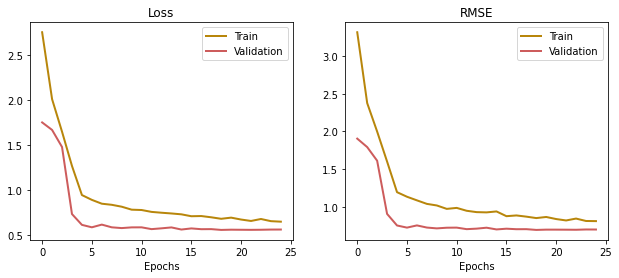

In [8]:
# grab history
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)

plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

ax = fig.add_subplot(1, 3, 2)

plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('RMSE');


In [ ]:
#
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("counts_2gram.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=25,
    callbacks=callbacks
)


## Submission to contest

In [ ]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(all_sc_y.inverse_transform(test_predictions))

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

In [ ]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)